In [1]:
import matplotlib
%matplotlib inline
from pylab import *
import caesar
import h5py, os, sys
import yt, pickle
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic as bst
from scipy.stats import binned_statistic_2d as bst2
from scipy.signal import savgol_filter as sgf

matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

safecolor={
    'silver':"#c0c0c0",
    'gray':"#808080",
    'black':"#000000",
    'red':"#ff0000",
    'maroon':"#800000",
    'yellow':"#ffff00",
    'olive':"#707030",
    'lime':"#00ee00",
    'green':"#009000",
    'aqua':"#00eeee",
    'teal':"#00a0a0",
    'blue':"#0000ff",
    'nave':"#000080",
    'fuchsia':"#ff00ff",
    'purple':"#900090"
}

/usr/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [34]:
#test 
d=caesar.load('/home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0039/Caesar_snap_128.hdf5')

yt : [INFO     ] 2021-06-01 14:30:44,458 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0039/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-06-01 14:30:58,068 Found 2438 halos
yt : [INFO     ] 2021-06-01 14:31:01,593 Found 1863 galaxies


In [37]:
d.galaxies[1500].info()

{'GroupID': 1500,
 'L_FIR': 0.0 Lsun,
 'absmag': {'2mass_h': -20.41149139404297,
            '2mass_j': -20.207626342773438,
            '2mass_ks': -20.151782989501953,
            'b': -18.274518966674805,
            'bessell_l': -19.433834075927734,
            'bessell_lp': -19.296131134033203,
            'bessell_m': -18.793733596801758,
            'buser_b': -18.34322738647461,
            'cfht_b': -18.37323570251465,
            'cfht_i': -19.793725967407227,
            'cfht_r': -19.398719787597656,
            'cousins_i': -19.7462100982666,
            'cousins_r': -19.393030166625977,
            'des_g': -18.639360427856445,
            'des_i': -19.701807022094727,
            'des_r': -19.334505081176758,
            'des_y': -20.098642349243164,
            'des_z': -19.987398147583008,
            'fors_r': -19.388916015625,
            'fors_v': -19.055551528930664,
            'galex_fuv': -10.48882007598877,
            'galex_nuv': -13.69189453125,
            

In [24]:
# prepare the data for GIZMO plot
if os.path.isfile('./data/zs-ms-relations.txt'):
    GSC_bh=np.loadtxt('./data/zs-ms-relations.txt')
else:
    GSC_bh=[]  # rid, hid, M200, M500, M*, vd, Mbh

    sn=128
    for i in np.arange(1,325):
        buf = '/home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_%04d/Caesar_snap_%03d.hdf5' % (i,sn)
        d=caesar.load(buf)

        for j in range(len(d.galaxies)):
            if (d.halos[d.galaxies[j].parent_halo_index].virial_quantities['m200c'].value > 1.0e13) & (d.halos[d.galaxies[j].parent_halo_index].contamination<0.01):
                GSC_bh.append([i, j, d.halos[d.galaxies[j].parent_halo_index].virial_quantities['m200c'].value, d.halos[d.galaxies[j].parent_halo_index].virial_quantities['m500c'].value, 
                               d.galaxies[j].masses['stellar'].value, d.galaxies[j].metallicities['stellar'].value,
                               d.galaxies[j].central.astype('uint8')])
    GSC_bh=np.asarray(GSC_bh)
    np.savetxt('./data/zs-ms-relations.txt', GSC_bh, header='# rid, hid, M200, M500, M*, z, central!')

yt : [INFO     ] 2021-03-09 22:23:24,210 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0001/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-03-09 22:23:24,347 Found 3034 halos
yt : [INFO     ] 2021-03-09 22:23:24,356 Found 1784 galaxies
<ipython-input-24-1973fc7e88f3>:16: DeprecationWarning: Applying '+' to a non-numerical array is ill-defined. Returning a copy, but in the future this will error.
  +(d.galaxies[j].central)])
yt : [INFO     ] 2021-03-09 22:23:25,631 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0002/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-03-09 22:23:26,958 Found 2608 halos
yt : [INFO     ] 2021-03-09 22:23:27,441 Found 1556 galaxies
yt : [INFO     ] 2021-03-09 22:23:27,614 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0003/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-03-09 22:23:28,004 Found 3523 halos
yt : [INFO     ] 2021-03-09 22:23:28,157 Found 2343 galaxies
yt : [INFO     ] 2021-03-09 22:23:28,568 Opening /home2/weiguang/data6/CL300_Caesa

In [23]:
d.halos[d.galaxies[j].parent_halo_index].contamination

0.0006037205747668101

In [26]:
+(False),+(True),d.galaxies[0].central.astype('uint8')

(0, 1, 1)

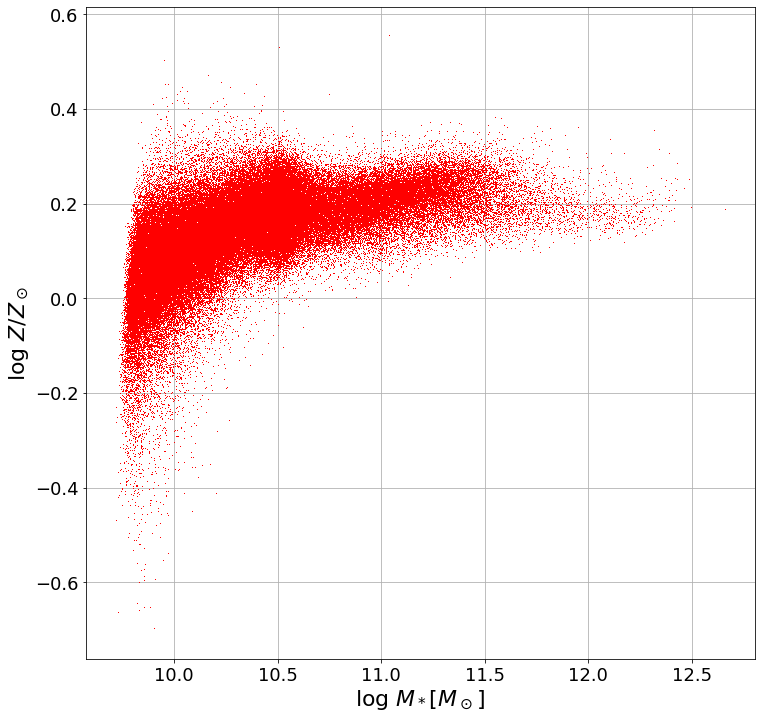

In [32]:
fig=figure(figsize=(12,12))
plot(np.log10(GSC_bh[:,4]),np.log10(GSC_bh[:,5]/0.0134),'r,')
xlabel(r'$\log\ M_* [M_\odot]$',fontsize=22)
ylabel(r'$\log\ Z/Z_\odot$',fontsize=22)
grid()